In [5]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import hybrid_functions as motor
import os
import logging

from datetime import datetime
logname=datetime.now().strftime("%d.%m.%y-%H.%M")+" - log.txt"
logging.basicConfig(filename=logname, level=logging.DEBUG, format="%(message)s")

if not os.path.exists("out"):
    os.makedirs("out")


###############################################################################
# Input parameters
###############################################################################

VOL_TANK = 8.1 * 0.001         # tank volume (m^3)

HEAD_SPACE = 0.3

NUM_INJ1 = 13.54                 # number of primary injector orifices

DIA_INJ1 = 2.5*0.001             # diameter of primary injector orifices (m)

DIA_PORT = 36.4*0.001              # diameter of fuel port (m)

LENGTH_PORT = 0.67            # length of fuel port (m)

DIA_FUEL = 75*0.001              # Outside diameter of fuel grain (m)

C_STAR_EFFICIENCY = 0.94      # Ratio between actual and theoretical

DIA_THROAT = 26*0.001          # nozzle throat diameter (m)

NOZZLE_EFFICIENCY = 0.97      # factor by which to reduce thrust coefficient

NOZZLE_AREA_RATIO = 4       # ratio of nozzle exit area to throat area

DIA_FEED = 0.010               # feed pipe diameter (m)

LENGTH_FEED = 2             # feed pipe length (m)

VALVE_MODEL_TYPE = 'ball'     # either 'kv' or 'ball' (models as thick orifice)

KV_VALVE = 5                  # used if VALVE_MODEL_TRY='kv'

DIA_VALVE = 0.01             # used if VALVE_MODEL_TRY='ball'

LENGTH_VALVE = 0.05           # used if VALVE_MODEL_TRY='ball'

DENSITY_FUEL = 1208            # solid fuel density (kg m^-3)

REG_COEFF = 0.06E-3	      # regression rate coefficient (usually 'a' in literature)

REG_EXP = 0.5		          # regression rate exponent (usually 'n' in literature)

PRES_EXTERNAL = 101325        # external atmospheric pressure at test site (Pa)

temp = 16 + 273.15            # initial tank temperature (K)



path = os.path.abspath(os.getcwd())
path = path + "/out" + "/" + str(0)
if not os.path.exists(path):
    os.makedirs(path)


#########################################################################################################

file = open(path + "/" + "data.txt", "w")
file.write("### INPUT ### \n\n")
# INPUT INCLUDE STEP

file.write(str("VOL_TANK " + str(VOL_TANK)) + " \n")
file.write(str("HEAD_SPACE " + str(HEAD_SPACE)) + " \n")
file.write(str("NUM_INJ1 " + str(NUM_INJ1)) + " \n")
file.write(str("DIA_INJ1 " + str(DIA_INJ1)) + " \n")
file.write(str("DIA_PORT " + str(DIA_PORT)) + " \n")
file.write(str("LENGTH_PORT " + str(LENGTH_PORT)) + " \n")
file.write(str("C_STAR_EFFICIENCY " + str(C_STAR_EFFICIENCY)) + " \n")
file.write(str("NOZZLE_EFFICIENCY " + str(NOZZLE_EFFICIENCY)) + " \n")
file.write(str("NOZZLE_AREA_RATIO " + str(NOZZLE_AREA_RATIO)) + " \n")
file.write(str("DIA_FEED " + str(DIA_FEED)) + " \n")
file.write(str("LENGTH_FEED " + str(LENGTH_FEED)) + " \n")
file.write(str("KV_VALVE " + str(KV_VALVE)) + " \n")
file.write(str("DIA_VALVE " + str(DIA_VALVE)) + " \n")
file.write(str("LENGTH_VALVE " + str(LENGTH_VALVE)) + " \n")
file.write(str("DENSITY_FUEL " + str(DENSITY_FUEL)) + " \n")
file.write(str("REG_COEFF " + str(REG_COEFF)) + " \n")
file.write(str("REG_EXP " + str(REG_EXP)) + " \n")
file.write(str("PRES_EXTERNAL " + str(PRES_EXTERNAL)) + " \n")
file.write(str("temp " + str(temp)) + " \n")
file.write("\n\n### INPUT ### \n")
# END INPUT INCLUDE STEP

# Create pipes for pipe-like things
portA   = motor.area(DIA_PORT)
fuelA   = motor.area(DIA_FUEL)
throatA = motor.area(DIA_THROAT)
feedA   = motor.area(DIA_FEED)
valveA  = motor.area(DIA_VALVE)
portL=LENGTH_PORT
feedL=LENGTH_FEED
valveL=LENGTH_VALVE
portD=DIA_PORT
feedD=DIA_FEED
valveD=DIA_VALVE
fuelD=DIA_FUEL


###############################################################################
# Initialize simulation
###############################################################################

if 'dracula' in plt.style.available:
    plt.style.use('dracula')
else:
    plt.style.use('seaborn-whitegrid')

dt = 2e-3  # time step (s)

#open propep data file
propep_file = open('data/L_Nitrous_S_HDPE.propep', 'r')
propep_data = propep_file.readlines()

# assign initial values
time = 0
mdotox = 0
impulse = 0
gamma_N2O = 2.5
blowdown_type = 'liquid'
entry_loss = 0

# temperature dependent properties of nitrous oxide inside the tank
lden, vden, hl, hg, cp, vap_pres, ldynvis, Zv, lu, vu = motor.thermophys(temp)

pres_cham = vap_pres-3e5 #for stability reasons

#calculate initial propellant masses and internal energy
lmass = VOL_TANK * (1 - HEAD_SPACE) * lden
vmass = VOL_TANK * HEAD_SPACE * vden
U=lu*lmass+vu*vmass
fuel_mass = (fuelA - portA) * portL * DENSITY_FUEL
tmass = lmass + vmass
print('Ox mass: '+str(lmass+vmass))
(  # create empty lists to fill with output data
    time_data,
    vap_pres_data,
    pres_cham_data,
    thrust_data,
    gox_data,
    prop_mass_data,
    manifold_pres_data,
    gamma_data,
    throat_data,
    nozzle_efficiency_data,
    exit_pressure_data,
    area_ratio_data,
    mach_exit_data,
    mdotox_data,

    # additional properties needed for the 6DOF simulation
    vden_data, vmass_data,
    lden_data, lmass_data,
    fuel_mass_data,
    U_data,
    temp_data,
    portD_data,
    rdot_data
) = [[] for _ in range(23)]


file.write(f"""\nInitial conditions:
    time: {time:.4f} s
    tank temperature: {temp-273.15:.2f} C
    lmass: {lmass:.4f} kg
    vmass: {vmass:.4f} kg
    vap_pres {vap_pres:.4f} Pa
    fuel thickness: {0.5 * (DIA_FUEL-DIA_PORT):.4f} m
    fuel mass {fuel_mass:.4f} kg
""")
file.write("\n")


missing_pressure=0 #I don't know...

Ox mass: 4.951882437164655


In [ ]:
###############################################################################
# Simulation loop
###############################################################################
time_steps=0
while True:
    time += dt  # increment time
    logging.debug('---------------'+str(round(time,4))+'----------------')
    time_steps+=1
    if time_steps%250==0:
        print('Time: '+str(round(time,1)))
    ##########################################################################print(time,'\n')
    # calculate feed system losses (only attemped for liquid phase)
    if mdotox > 0 and lmass > 0:
        flow_speed = mdotox / (lden * feedA)
        entry_loss = 0.5 * lden * (flow_speed ** 2)  # loss at tank entry

        reynolds = lden * flow_speed * feedD / ldynvis
        f = motor.Nikuradse(reynolds)

        # loss in pipe
        vis_pdrop = 0.25 * f * lden * (flow_speed**2) * feedL / feedD
        logging.debug('vis_pdrop '+str(vis_pdrop/1e6))

        if VALVE_MODEL_TYPE == 'ball':
            #valve loss from full bore ball valve modelled as thick orifice
            valve_loss = (0.5 * lden * flow_speed * flow_speed
                          * motor.ball_valve_K(reynolds, feedD, valveD,
                                               valveL))

        elif VALVE_MODEL_TYPE == 'kv':
            valve_loss = (1.296e9 * mdotox * mdotox /
                          (lden * KV_VALVE * KV_VALVE))

        # sum pressure drops
        manifold_pres = vap_pres - entry_loss - vis_pdrop-missing_pressure# - valve_loss
    else:
        manifold_pres = vap_pres
    logging.debug('vap pres '+str(vap_pres/1e6))
    logging.debug('no2 pres '+str(manifold_pres/1e6))
    logging.debug('entry loss '+str(entry_loss/1e6))
    #calculate injector pressure drop
    inj_pdrop = manifold_pres - pres_cham
    logging.debug('inj pdrop '+str(inj_pdrop/1e6))
    logging.debug('T '+str(temp))

    if inj_pdrop < 0.15 and time > 0.5:
        print(f'FAILURE: Reverse flow occurred at t={time} s')
        break



    """Pressure is highly unstable during simulation, so additional iteration is used to find stable configuration
    of oxidizer flow and chamber pressure given only tank conditions (temperature and mass composition"""

    pressure_iteration=0
    while True:


        # model tank emptying
        logging.debug('pres cham '+str(pres_cham/1e6))
        if blowdown_type == 'liquid':
            # liquid phase blowdown

            mdotox, mdotspi, mdothem, h2 = motor.dyer_injector(
                pres_cham, DIA_INJ1, lden, inj_pdrop,
                hl, manifold_pres, vap_pres, NUM_INJ1
            )

            # find new mass of tank contents after outflow
            tmass_new = tmass - mdotox * dt

            # liquid mass prior to vaporization
            lmass_pre_vap = lmass - (mdotox * dt)

            # lmass post vaporization
            lmass_post_vap = (vden * VOL_TANK - tmass_new) / (vden / lden - 1)
            
            lmass_new = lmass_post_vap
            vmass_new = tmass_new - lmass_new
                
            if lmass_new<0.01:  # check for liquid depletion
                file.write(f'starting vapour blowdown, vapour mass is {vmass+lmass:.4f} kg')
                file.write("\n")
                file.write(f'injector pressure drop at liquid depletion was '
                      f'{100 * inj_pdrop / pres_cham:.4f}%')
                file.write("\n")
                blowdown_type = 'vapour'
                lmass_new = 0
                vmass_new = tmass_new

                # define tank parameters at liquid depletion
                vmass_ld, temp_ld, vden_ld, vap_pres_ld, Z_ld = (vmass_new, temp,
                                                           vden, vap_pres, Zv)

            else:  # continue with liquid blowdown stage
                # update nitrous thermophysical properties given new temperature
                temp = motor.EQTemp (U, tmass_new, VOL_TANK)
                U_new = U - hl*mdotox*dt
                lden, vden, hl, hg, cp, vap_pres, ldynvis, Zv, lu, vu = motor.thermophys(temp)

        else:
            # vapour phase blowdown

            # calculations for injector orifices
            vden=v_mass/VOL_TANK
            #some things=thermophys_vapour(vden)
            mdotox= NUM_INJ1 * motor.vapour_injector(DIA_INJ1, vden, inj_pdrop) #old method, considering changing it
            mdotox=motor.dyer_injector_vapour(vden, DIA_INJ1, NUM_INJ1)
            vmass_new = vmass - dt * mdotox  # sum flow from 3 types of orifice
            # find current tank vapour parameters
            corr=0.2
            Z2_new = motor.Z2_solve(temp+corr, vap_pres)
            if (Z2_new>0.3):
                Z2 = Z2_new

            #isentropic assumption
            temp = temp_ld * pow(Z2 * vmass / (Z_ld * vmass_ld), gamma_N2O-1)
            vap_pres = vap_pres_ld * pow(temp / temp_ld, gamma_N2O / (gamma_N2O-1))
            vden = vden_ld * pow(temp / temp_ld, 1 / (gamma_N2O-1))

        # check for excessive mass flux
        #if mdotox / port.A > 600:
            #print(f'Failure: oxidizer flux too high: {mdotox / port.A:.2f}')
            #DO NOT BREAK< BECAUSE ENGINE WORKS JUST FINE EVEN WITH THEORY BROKEN!!! TRY TO FIX THIS ISSUE LATER!!!
            #break

        # fuel port calculation
        rdot = REG_COEFF * pow(mdotox/portA, REG_EXP)
        mdotfuel = rdot * DENSITY_FUEL * np.pi * portD * portL

        logging.debug('rdot '+str(rdot*1000))
        logging.debug('mdotox '+str(mdotox))
        logging.debug('mdothem '+str(mdothem))
        logging.debug('mdotspi '+str(mdotspi))
        logging.debug('mdotfuel '+str(mdotfuel))

        portD_new = portD + 2*rdot*dt
        portA_new=motor.area(portD_new)
        if portD_new > fuelD: #check for depleted fuel grain
            print("fuel depleted")
            break

        fuel_mass_new = (fuelA - portA_new) * portL * DENSITY_FUEL


        # lookup characteristic velocity using previous
        # pres_cham and current OF from propep data
        c_star = (motor.c_star_lookup(pres_cham, mdotox / mdotfuel, propep_data)
                  * C_STAR_EFFICIENCY)
        logging.debug('current o/f: ' + str(mdotox / mdotfuel))

        # calculate current chamber pressure

        pres_cham_iter =(mdotox + mdotfuel) * c_star / throatA
        logging.debug('pres cham NEW '+str(pres_cham_iter/1e6))
        delta_pres_cham=abs(pres_cham_iter-pres_cham)
        if delta_pres_cham<1.5e5:
            if pressure_iteration>1:
                print('Pressure converged with more than 1 iteration: '+str(pressure_iteration))
            break
        alfa=0.1
        pres_cham=(1-alfa)*pres_cham+alfa*pres_cham_iter
        pressure_iteration+=1
        logging.debug('---Iter: '+str(pressure_iteration)+' of '+str(round(time,2))+'---')
        if pressure_iteration>500:
            print('NO CONVERGANCE!')
            break
        logging.debug('pres cham '+str(pres_cham/1e6))
    
    #keep more global variables from changes during pressure iteration
    tmass=tmass_new
    lmass=lmass_new
    vmass=vmass_new
    portD=portD_new
    portA=portA_new
    fuel_mass=fuel_mass_new
    U=U_new
    
    if portD > fuelD: #check for depleted fuel grain
            print("fuel depleted")
            break

    # lookup ratio of specific heats from propep data file
    gamma = motor.gamma_lookup(pres_cham, mdotox/mdotfuel, propep_data)

    # performance calculations
    # find nozzle exit static pressure
    mach_exit = motor.mach_exit(gamma, NOZZLE_AREA_RATIO)
    pres_exit = pres_cham * pow(1 + (gamma - 1) * mach_exit * mach_exit * 0.5,
                                -gamma / (gamma - 1))


    # motor performance calculations
    thrust = NOZZLE_EFFICIENCY * (
        throatA * pres_cham * np.sqrt(
            2 * gamma**2 / (gamma - 1)
            * pow(2 / (gamma + 1), (gamma + 1) / (gamma - 1))
            * (1 - pow(pres_exit / pres_cham, 1 - 1 / gamma))
        ) + (pres_exit - PRES_EXTERNAL) * throatA * NOZZLE_AREA_RATIO)

    if thrust<10 and time_steps>10:
        print('Very low thrust - simulation interrupted - up to change')
        break
    #update data lists
    time_data.append(time)
    vap_pres_data.append(vap_pres)
    pres_cham_data.append(pres_cham)
    manifold_pres_data.append(manifold_pres)
    thrust_data.append(thrust)
    gox_data.append(mdotox / portA)
    mdotox_data.append(mdotox)
    prop_mass_data.append(lmass + vmass + fuel_mass)
    gamma_data.append(gamma)
    throat_data.append(DIA_THROAT)
    nozzle_efficiency_data.append(NOZZLE_EFFICIENCY)
    exit_pressure_data.append(pres_exit)
    area_ratio_data.append(NOZZLE_AREA_RATIO)
    mach_exit_data.append(mach_exit)

    #additional data for the 6DOF simulation
    vmass_data.append(vmass)
    vden_data.append(vden)
    lden_data.append(lden)
    lmass_data.append(lmass)
    fuel_mass_data.append(fuel_mass)
    U_data.append(U)
    temp_data.append(temp)
    portD_data.append(portD)
    rdot_data.append(rdot)

    

print('end')

11621.390175130193
202.4
O/F ratio: 5.195032262230734


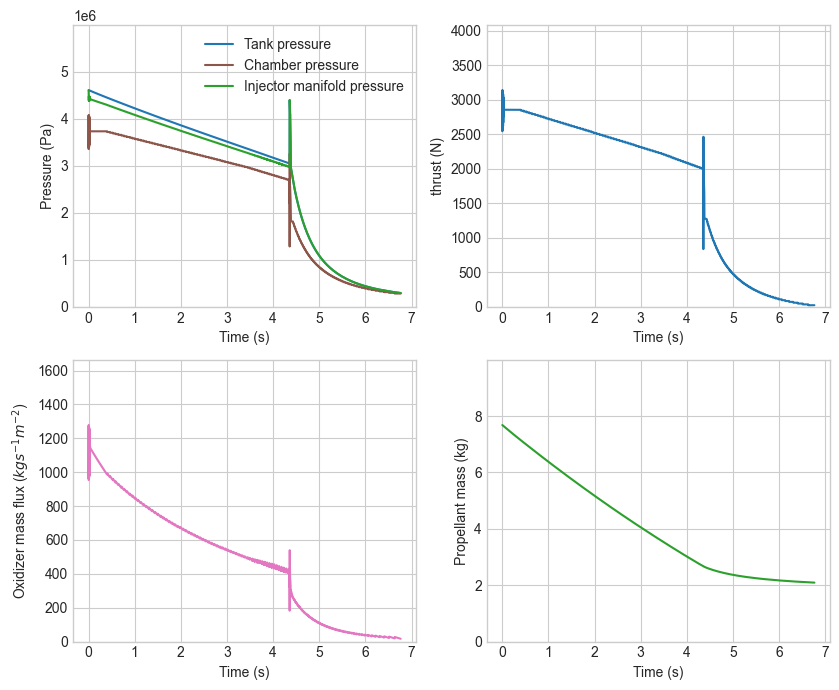

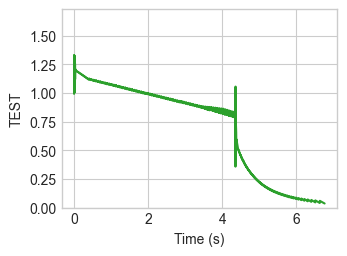

In [7]:
###############################################################################
# Print and plot results
###############################################################################

file.write(str("\nFinal conditions:\ntime:" + str(time)))
file.write(str("\ntank temperature:" + str(temp-273.15)))
file.write(str("\nlmass:" +  str(lmass) + "kg"))
file.write(str("\nvmass:" + str(vmass) + "kg"))
file.write(str("\nvap_pres:" + str(vap_pres) +'Pa'))
file.write(str("\nfuel thickness:" + str((DIA_FUEL-DIA_PORT)/2) + 'm'))
file.write(str('\nfuel mass' +  str(fuel_mass) + 'kg'))
file.write("\n")
impulse = dt * sum(thrust_data[:len(time_data)])
print(impulse)
print(round(impulse/(prop_mass_data[0]-fuel_mass)/9.81,1)) #Isp

file.write("\nPerformance results:")
file.write(str('\nInitial thrust:' + str(thrust_data[3]) + "N"))
file.write(str('\nmean thrust:' +  str(np.mean(thrust_data)) + 'N'))
file.write(str('N\nimpulse:' + str(impulse) + 'Ns'))
file.write(str('\nmean Isp:' + str(impulse/(prop_mass_data[0]-fuel_mass)/9.81)))
file.write("\n")
delta_fuel=fuel_mass_data[0]-fuel_mass_data[-1];
delta_ox=(lmass_data[0]-lmass_data[-1])+(vmass_data[0]-vmass_data[-1]);
of_ratio=delta_ox/delta_fuel;
print('O/F ratio: ' + str(of_ratio))
#plot pressures
plt.figure(figsize=(8.5, 7))
plt.subplot(221)
plt.plot(time_data, vap_pres_data, 'C0', label='Tank pressure')
plt.plot(time_data, pres_cham_data, 'C5', label='Chamber pressure')
plt.plot(time_data, manifold_pres_data, 'C2', label='Injector manifold pressure')
plt.ylabel('Pressure (Pa)')
plt.ylim(0, max(vap_pres_data)*1.3)
plt.xlabel('Time (s)')
plt.ylabel('Pressure (Pa)')
plt.legend()
plt.tight_layout()

#plot thrust
plt.subplot(222)
plt.plot(time_data, thrust_data)
plt.xlabel('Time (s)')
plt.ylabel('thrust (N)')
plt.ylim(0, max(thrust_data)*1.3)
plt.tight_layout()

#plot massflux
plt.subplot(223)
plt.plot(time_data, gox_data, 'C6')
plt.xlabel('Time (s)')
plt.ylabel('Oxidizer mass flux ($kg s^{-1} m^{-2}$)')
plt.ylim(0, max(gox_data)*1.3)
plt.tight_layout()

#plot mass of propellant
plt.subplot(224)
plt.plot(time_data, prop_mass_data, 'C2')
plt.xlabel('Time (s)')
plt.ylabel('Propellant mass (kg)')
plt.ylim(0, max(prop_mass_data)*1.3)
plt.tight_layout()

plt.savefig(path + "/plot.png")
plt.show()

plt.subplot(224);
plt.plot(time_data, mdotox_data, 'C2');
plt.xlabel('Time (s)');
plt.ylabel('TEST');
plt.ylim(0, max(mdotox_data)*1.3);
plt.tight_layout();
plt.show()

###############################################################################
# generate motor_output.csv for trajectory simulation
###############################################################################
with open("motor_out.csv", "w", newline='') as motor_file:
    motor_file.truncate()
    motor_write = csv.writer(motor_file)
    motor_write.writerow([
        'Time',
        'Propellant mass (kg)',
        'Chamber pressure (Pa)',
        'Throat diameter (m)',
        'Nozzle inlet gamma',
        'Nozzle efficiency',
        'Exit static pressure (Pa)',
        'Area ratio',
        'Vapour Density (kg/m^3)',
        'Vapour Mass (kg)',
        'Liquid Density (kg/m^3)',
        'Liquid Mass (kg)',
        'Solid Fuel Mass (kg)',
        'Solid Fuel Density (kg/m^3)',
        'Solid Fuel Outer Diameter (m)',
        'Solid Fuel Length (m)',
        'Thrust (N)'
    ])

    for i, _ in enumerate(time_data):
        motor_write.writerow([time_data[i], prop_mass_data[i],
                              pres_cham_data[i],
                              throat_data[i], gamma_data[i],
                              nozzle_efficiency_data[i], exit_pressure_data[i],
                              area_ratio_data[i],
                              vden_data[i], vmass_data[i],
                              lden_data[i], lmass_data[i], fuel_mass_data[i],
                              DENSITY_FUEL, DIA_FUEL, LENGTH_PORT,thrust_data[i]])

    motor_write.writerow([time_data[-1] + dt, fuel_mass, pres_cham_data[-1],
                          throat_data[-1], gamma_data[-1],
                          nozzle_efficiency_data[-1], exit_pressure_data[-1],
                          area_ratio_data[-1],
                          vden_data[-1], 0,
                          lden_data[-1], lmass_data[-1], fuel_mass_data[-1],
                          DENSITY_FUEL, DIA_FUEL, LENGTH_PORT,thrust_data[-1]])


###############################################################################
# generate a RASP motor file for RAS Aero
###############################################################################

RASP_DIA = 160      # motor diameter in mm
RASP_LENGTH = 3000  # motor length in mm
RASP_DRY = 40       # motor dry mass in kg

with open("hybrid.eng", "w+") as rasp_file:

    rasp_file.write(';\n')
    rasp_file.write(f'Pulsar {RASP_DIA} {RASP_LENGTH} P'
                    f' {prop_mass_data[0]:.2f}'
                    f' {prop_mass_data[0] + RASP_DRY:.2f} CUSF\n')

    for i in range(31):
        t = int(i * len(time_data) / 31)
        rasp_file.write(
                f'\t{float(time_data[t]):.2f} {float(thrust_data[t]):.2f}\n')

    rasp_file.write(f'\t{float(time_data[-1]):.2f} 0.0\n')
    rasp_file.write(';')



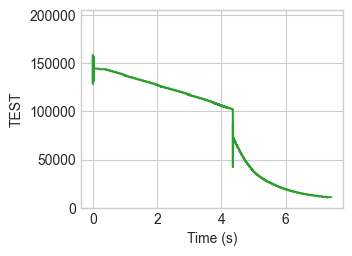

In [14]:
plt.subplot(224);
foo=exit_pressure_data
plt.plot(time_data, foo, 'C2');
plt.xlabel('Time (s)');
plt.ylabel('TEST');
plt.ylim(0, max(foo)*1.3);
plt.tight_layout();
plt.show()

In [ ]:
2.733/((motor.area(DIA_FUEL)-motor.area(DIA_PORT))*LENGTH_PORT)

In [ ]:
tankA=motor.area(0.130)
flow_speed_tank=mdotox_data[3] / (lden_data[3] * tankA)
entry_loss_tank = 0.5 * lden_data[3] * (flow_speed_tank ** 2)
print(str(round(entry_loss_tank,4)))

In [ ]:
r=2.21/1000 #based on AT static fire
gox=204.7 #based on AT static fire
n=0.7 #guess
goxn=gox**n
a=r/goxn
a